# Initiation
**Project:** Qubit Calibration and Noise Analysis <br>
**Author:** Oliver J <br>
**Date:** 17 Feb., 2026 <br>

# 1. Objective
Utilizing Pulse Level Control to calibrate superconducting qubit, and 
measure some relevant properties:
1. **Frequnecy Sweep** to find the resonance frequency of the qubit
2. **Rabi Oscillation** to calibrate amplitude of $\pi$ pulse for exact qubit flip
3. **T1, T2 Measurement** to measure T1 and T2 for qubits

# 2. Environment Imports
Qiskit Experiment module has some standardized process flow of calibration experiments.

A mock backend was constrcuted from scratch, which will be explained in detail. This mock backend could be 
encapsulated in the future for reference.


In [49]:
# 1. Array calculation and plotting
import numpy as np
import matplotlib.pyplot as plt

# 2. Qiskit 
import qiskit
from qiskit import QuantumCircuit, transpile, pulse
from qiskit.circuit import Measure, Delay, Parameter
from qiskit.quantum_info import Operator
from qiskit.providers import QubitProperties
from qiskit.transpiler import Target, InstructionProperties
from qiskit import pulse 

# 3. Qiskit dynamics
import qiskit_dynamics
from qiskit_dynamics import Solver, DynamicsBackend

# 4. Qiskit experiments
import qiskit_experiments
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import QubitSpectroscopy, Rabi, T1, T2Ramsey
from qiskit_experiments.calibration_management import Calibrations

# 5. Qiskit traditional backend
import qiskit_aer as aer
from qiskit_aer.primitives import Estimator
from qiskit_ibm_runtime.fake_provider import FakeValenciaV2, FakeArmonk

print('----- envs checked -----')

----- envs checked -----


# 3. Construct a qubit and apply frequency sweep to find resonance peak

---- 1. Construct a qubit (Solver) ----
---- 2. Initialize Dynamics backend and assign kwargs ----
---- 3. Frequency Sweep ----
---- 4. Finished ----


/opt/anaconda3/envs/quant_lab/lib/python3.10/site-packages/asteval/asteval.py:939: FutureWarning: AffineScalarFunc.__abs__() is deprecated. It will be removed in a future release.
  out = func(*args, **keywords)


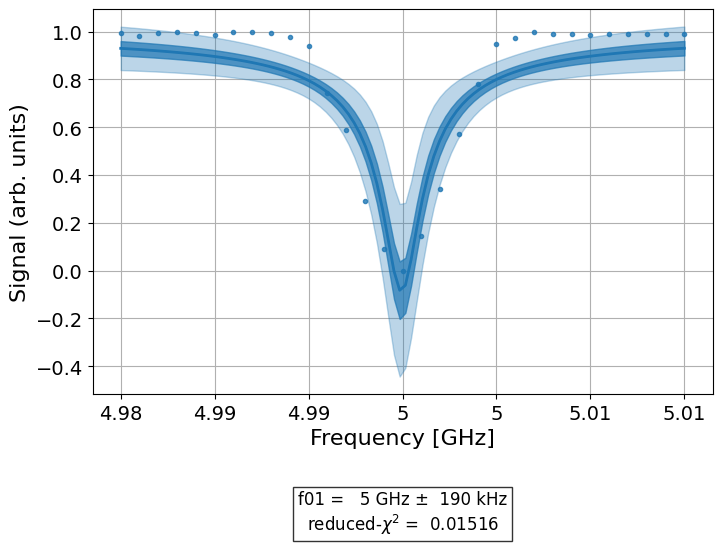

Resonance Frequency: 4.99994 GHz


In [50]:
print("---- 1. Construct a qubit (Solver) ----")
qubit_freq = 5.0e9     
drive_strength = 20e6  
dt = 0.222e-9          

Z = Operator.from_label('Z')
X = Operator.from_label('X')

solver = Solver(
    static_hamiltonian= -0.5 * 2 * np.pi * qubit_freq * Z,
    hamiltonian_operators=[2 * np.pi * drive_strength * X],
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": qubit_freq},
    dt=dt
)

print("---- 2. Initialize Dynamics backend and assign kwargs ----")
pulse_backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[2],
    solver_options={"method": "RK45", "atol": 1e-6, "rtol": 1e-6}
)

target = Target(num_qubits=1, dt=dt) 
target.qubit_properties = [QubitProperties(frequency=qubit_freq)]

# 🌟 核心补丁：手搓一个“测量脉冲调度表 (Schedule)”
# 相当于给 ADC 写了一段触发脚本
with pulse.build(name="measure") as meas_sched:
    # 告诉硬件：在 AcquireChannel(0) 上持续采集 400 个点的数据，存到 MemorySlot(0)
    pulse.acquire(400, pulse.AcquireChannel(0), pulse.MemorySlot(0))

# 把这段波形脚本 (meas_sched) 喂给 calibration 参数！
target.add_instruction(
    Measure(), 
    {(0,): InstructionProperties(duration=400*dt, calibration=meas_sched)}
)
target.add_instruction(Delay(Parameter('t')), {(0,): InstructionProperties()})

pulse_backend._target = target 
pulse_backend._dt = dt  

print("---- 3. Frequency Sweep ----")
frequencies = np.linspace(qubit_freq - 15e6, qubit_freq + 15e6, 31)

spec_exp = QubitSpectroscopy(physical_qubits=[0], frequencies=frequencies)
exp_data = spec_exp.run(backend=pulse_backend).block_for_results()

print("---- 4. Finished ----")
if len(exp_data.data()) > 0:
    display(exp_data.figure(0))
    fit_results = exp_data.analysis_results(0)
    freq = fit_results.value.params['freq']
    #print(fit_results.value.params['freq'])
    print(f"Resonance Frequency: {freq / 1e9:.5f} GHz")
else:
    print("no data")